# Assignment #4: Decision Trees and Random Forest

In this assignment we will learn about decision/regression trees.

## Implement the regression tree algorithm from scratch

For the splitting criteria use a criteria of your choice. This is why our implementation will allow the following splitting criterias:
- RSS
- MSE
- MAE
- RSE
- R2


We have to also select a criteria to stop splitting the nodes, which will affect how complex the tree will be. We will implement:
- maximum depth of the tree
- minimal number of instances in a leaf


In [5]:
import numpy as np

We will first start by implementing a class that will be representing a node in the regression tree.

In [8]:
class TreeNode:
  def __init__(self, feature_index = None, threshold = None, left = None, right = None, value = None):
    # Index of the feature used for splitting
    self.feature_index = feature_index
    # Threshold value used for splitting
    self.threshold = threshold
    # Left child with values smaller or equal to the threshold
    self.left = left
    # Right child with values bigger than the threshold
    self.right = right
    # Best score for each attribute split and avg of the leaves
    self.value = value

Now we can also write the code for the regression tree algorithm.

In [11]:
class RegressionTree:
  def __init__(self, max_depth=9, min_samples = 20, splitting_criteria = 'RSS'):
    # Maximum depth of the tree
    self.max_depth = max_depth
    # Minimum samples to stop splitting the nodes
    self.min_samples = min_samples
    # Criteria used for splitting the node (RSS, MSE, MAE, RSE, R2)
    self.splitting_criteria = splitting_criteria
    self.root = None


  def fit(self, X, y):
    self.root = self.build_tree(X, y, depth = 0)
    return self.root


  def best_split(self, X, y, num_features):
    best_score, best_feature, best_threshold = None, None, None

    for feature_index in range(num_features):
      # Get only the unique values of the feature as potential thresholds
      feature_column = X[:, feature_index]
      unique_values = np.unique(feature_column)
      # Calculate the thresholds as average btw each 2 points starting from the smallest
      thresholds = (unique_values[:-1] + unique_values[1:]) / 2

      for threshold in thresholds:
        # Get the values for the left and right side of the threshold
        y_left = y[feature_column <= threshold]
        y_right = y[feature_column > threshold]

        # Calculate the average of each split and use it as prediction value in the evaluation
        pred_left = np.mean(y_left)
        pred_right = np.mean(y_right)

        # Calculate the score for the current threshold based on the splitting criteria
        if self.splitting_criteria == 'RSS' or self.splitting_criteria == 'RSE' or self.splitting_criteria == 'R2':
          rss_left = np.square(np.subtract(y_left, pred_left)).sum()
          rss_right = np.square(np.subtract(y_right, pred_right)).sum()
          if self.splitting_criteria == 'RSS':
            score = rss_left + rss_right
          elif self.splitting_criteria == 'RSE':
            rse_left = np.sqrt(rss_left / (len(y_left) - 2))
            rse_right = np.sqrt(rss_right / (len(y_right) - 2))
            score = rse_left + rse_right
          elif self.splitting_criteria == 'R2':
            tss_left = np.square(np.subtract(y_left, y_left.mean())).sum()
            tss_right = np.square(np.subtract(y_right, y_right.mean())).sum()
            r2_left = 1 - (rss_left / tss_left)
            r2_right = 1 - (rss_right / tss_right)
            score = r2_left + r2_right
        elif self.splitting_criteria == 'MSE':
          left_mse = np.square(np.subtract(y_left, pred_left)).mean()
          right_mse = np.square(np.subtract(y_right, pred_right)).mean()
          score = left_mse + right_mse
        elif self.splitting_criteria == 'MAE':
          left_mae = np.abs(np.subtract(y_left, pred_left)).mean()
          right_mae = np.abs(np.subtract(y_right, pred_right)).mean()
          score = left_mae + right_mae

        # See if this is the best score based on the splitting criteria
        if best_score is None or (score < best_score and self.splitting_criteria != 'R2') or (score > best_score and self.splitting_criteria == 'R2'):
          best_score = score
          best_feature = feature_index
          best_threshold = threshold

    return best_feature, best_threshold, best_score


  def build_tree(self, X, y, depth):
    num_samples, num_features = X.shape

    # No split is possible so this is a leaf node
    if depth >= self.max_depth or num_samples <= self.min_samples:
      return TreeNode(value=np.mean(y))

    # Split is possible so we have to find the best one
    best_feature, best_threshold, best_score = self.best_split(X, y, num_features)
    # No split is possible so this is a leaf node
    if best_feature is None:
      return TreeNode(value=np.mean(y))

    # Split the data into two parts based on the threshold
    feature_column = X[:, best_feature]
    X_left = X[feature_column <= best_threshold, :]
    y_left = y[feature_column <= best_threshold]
    X_right = X[feature_column > best_threshold, :]
    y_right = y[feature_column > best_threshold]

    # Build the subtrees
    left_subtree = self.build_tree(X_left, y_left, depth + 1)
    right_subtree = self.build_tree(X_right, y_right, depth + 1)

    return TreeNode(best_feature, best_threshold, left_subtree, right_subtree, best_score)


  def predict(self, X):
      predictions = []
      for sample in X:
        predictions.append(self.predict_sample(self.root, sample))
      return predictions


  def predict_sample(self, node, sample):
      if node.left is None and node.right is None:
        return node.value
      if sample[node.feature_index] <= node.threshold:
        return self.predict_sample(node.left, sample)
      return self.predict_sample(node.right, sample)


  def evaluate(self, y_true, y_pred):
    # Calculate the MSE
    mse = np.square(np.subtract(y_true, y_pred)).mean()
    # Calculate the MAE
    mae = np.abs(np.subtract(y_true, y_pred)).mean()
    # Calculate the RSE
    rss = np.square(np.subtract(y_true, y_pred)).sum()
    rse = np.sqrt(rss / (len(y_true) - 2))
    # Calculate the R^2
    tss = np.square(np.subtract(y_true, y_true.mean())).sum()
    r2_score = 1 - (rss / tss)

    return mse, mae, rse, r2_score


## Download the dataset "House price"

In this dataset "price" is the target.

In [12]:
import pandas as pd

In [14]:
house_price = pd.read_csv('data/House_Price.csv')
house_price.head()

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,waterbody,rainfall,bus_ter,parks
0,24.0,0.00632,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,YES,5.480,11.1920,River,23,YES,0.049347
1,21.6,0.02731,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,NO,7.332,12.1728,Lake,42,YES,0.046146
2,34.7,0.02729,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,NO,7.394,101.1200,None,38,YES,0.045764
3,33.4,0.03237,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,YES,9.268,11.2672,Lake,45,YES,0.047151
4,36.2,0.06905,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,NO,8.824,11.2896,Lake,55,YES,0.039474


First thing we have to do is encode the columns **airport**, **waterbody** and **bus_ter** since they are categorical and strings and won't allow us to train the model.

In [15]:
house_price['airport'].unique()

array(['YES', 'NO'], dtype=object)

In [16]:
house_price['airport'] = house_price['airport'].map({'YES': 1, 'NO': 0})
house_price['airport'].unique()

array([1, 0])

In [17]:
house_price['waterbody'].unique()

array(['River', 'Lake', 'None', 'Lake and River'], dtype=object)

In [18]:
house_price['waterbody_1'] = (house_price['waterbody'] == 'River').astype(int)
house_price['waterbody_2'] = (house_price['waterbody'] == 'Lake').astype(int)
house_price['waterbody_3'] = (house_price['waterbody'] == 'Lake and River').astype(int)
house_price['waterbody_1'].unique(), house_price['waterbody_2'].unique(), house_price['waterbody_3'].unique()

(array([1, 0]), array([0, 1]), array([0, 1]))

In [19]:
house_price = house_price.drop('waterbody', axis=1)

In [20]:
house_price['bus_ter'].unique()

array(['YES'], dtype=object)

As we can see for this column we have only one value for each row, which means that it is not very informative and we can drop it.

In [21]:
house_price = house_price.drop('bus_ter', axis=1)

In [22]:
house_price.head()

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,rainfall,parks,waterbody_1,waterbody_2,waterbody_3
0,24.0,0.00632,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,1,5.480,11.1920,23,0.049347,1,0,0
1,21.6,0.02731,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,0,7.332,12.1728,42,0.046146,0,1,0
2,34.7,0.02729,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,0,7.394,101.1200,38,0.045764,0,0,0
3,33.4,0.03237,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,1,9.268,11.2672,45,0.047151,0,1,0
4,36.2,0.06905,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,0,8.824,11.2896,55,0.039474,0,1,0


Let's check if there are some missing values or duplicate samples in this data.

In [23]:
house_price[house_price.duplicated()]

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,rainfall,parks,waterbody_1,waterbody_2,waterbody_3


In [24]:
missing_ratio = house_price.isnull().mean()
missing_ratio = missing_ratio[missing_ratio > 0]
missing_ratio

n_hos_beds    0.01581
dtype: float64

We see that only a small percentage of the data is missing for the column **n_hos_beds** so it will be better to just impute mean of the other values to the missing rows.

In [25]:
missing_values_index = house_price[house_price.isnull().any(axis=1)].index
house_price.iloc[missing_values_index]

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,rainfall,parks,waterbody_1,waterbody_2,waterbody_3
50,19.7,0.08873,35.64,0.439,5.963,45.7,7.08,6.55,7.00,6.63,23.2,13.45,1,NaN,11.1576,21,0.040389,1,0,0
112,18.8,0.12329,40.01,0.547,5.913,92.9,2.55,2.23,2.56,2.07,22.2,16.21,1,NaN,15.1504,35,0.057644,1,0,0
215,25.0,0.19802,40.59,0.489,6.182,42.4,4.15,3.81,3.96,3.87,21.4,9.47,1,NaN,12.2000,30,0.047925,0,1,0
260,33.8,0.54011,33.97,0.647,7.203,81.8,2.12,1.95,2.37,2.01,27.0,9.59,1,NaN,11.2704,21,0.068041,0,1,0
359,22.6,4.26131,48.10,0.770,6.112,81.3,2.78,2.38,2.56,2.31,19.8,12.67,0,NaN,14.1808,26,0.074239,0,1,0
403,8.3,24.80170,48.10,0.693,5.349,96.0,1.75,1.38,1.88,1.80,19.8,19.77,1,NaN,15.0664,40,0.067689,1,0,0
416,7.5,10.83420,48.10,0.679,6.782,90.8,1.90,1.54,2.04,1.80,19.8,25.79,1,NaN,10.0600,35,0.064619,1,0,0
496,19.7,0.28960,39.69,0.585,5.390,72.9,2.86,2.61,2.98,2.74,20.8,21.14,0,NaN,12.1576,44,0.061026,1,0,0


In [26]:
mean_value = house_price['n_hos_beds'].mean()
house_price = house_price.fillna(mean_value)
house_price.iloc[missing_values_index]

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,rainfall,parks,waterbody_1,waterbody_2,waterbody_3
50,19.7,0.08873,35.64,0.439,5.963,45.7,7.08,6.55,7.00,6.63,23.2,13.45,1,7.899767,11.1576,21,0.040389,1,0,0
112,18.8,0.12329,40.01,0.547,5.913,92.9,2.55,2.23,2.56,2.07,22.2,16.21,1,7.899767,15.1504,35,0.057644,1,0,0
215,25.0,0.19802,40.59,0.489,6.182,42.4,4.15,3.81,3.96,3.87,21.4,9.47,1,7.899767,12.2000,30,0.047925,0,1,0
260,33.8,0.54011,33.97,0.647,7.203,81.8,2.12,1.95,2.37,2.01,27.0,9.59,1,7.899767,11.2704,21,0.068041,0,1,0
359,22.6,4.26131,48.10,0.770,6.112,81.3,2.78,2.38,2.56,2.31,19.8,12.67,0,7.899767,14.1808,26,0.074239,0,1,0
403,8.3,24.80170,48.10,0.693,5.349,96.0,1.75,1.38,1.88,1.80,19.8,19.77,1,7.899767,15.0664,40,0.067689,1,0,0
416,7.5,10.83420,48.10,0.679,6.782,90.8,1.90,1.54,2.04,1.80,19.8,25.79,1,7.899767,10.0600,35,0.064619,1,0,0
496,19.7,0.28960,39.69,0.585,5.390,72.9,2.86,2.61,2.98,2.74,20.8,21.14,0,7.899767,12.1576,44,0.061026,1,0,0


In [27]:
len(house_price[house_price.isnull().any(axis=1)])

0

In [28]:
house_price.head(5)

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,rainfall,parks,waterbody_1,waterbody_2,waterbody_3
0,24.0,0.00632,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,1,5.480,11.1920,23,0.049347,1,0,0
1,21.6,0.02731,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,0,7.332,12.1728,42,0.046146,0,1,0
2,34.7,0.02729,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,0,7.394,101.1200,38,0.045764,0,0,0
3,33.4,0.03237,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,1,9.268,11.2672,45,0.047151,0,1,0
4,36.2,0.06905,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,0,8.824,11.2896,55,0.039474,0,1,0


Now when we have preprocessed our data the only thing left to do is split it into training and test set of dependant and independant attributes.

In [30]:
X = house_price.iloc[:, 1:].values
y = house_price.iloc[:, 0].values

In [36]:
X

array([[6.3200e-03, 3.2310e+01, 5.3800e-01, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.7310e-02, 3.7070e+01, 4.6900e-01, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.7290e-02, 3.7070e+01, 4.6900e-01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [6.0760e-02, 4.1930e+01, 5.7300e-01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0959e-01, 4.1930e+01, 5.7300e-01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.7410e-02, 4.1930e+01, 5.7300e-01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [ ]:
y[:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Evaluation of the model

Build a regression tree for the selected dataset, test it using cross-validation and also compare it with Scikit-learn's regression tree. Use the same cross-validation splits on both models.

First let's test our implementation and see what results we get using different splitting criterias and different stopping criterias.

In [39]:
from tqdm import tqdm

In [40]:
splitting_criterias = ['RSS', 'MSE', 'MAE', 'RSE', 'R2']
min_samples_values = [1, 5, 10, 20, 30, 40]
max_depth_values = [3, 5, 7, 9, 11, 15]
results = []

for criteria in tqdm(splitting_criterias, desc='Splitting Criteria'):
  for min_samples in min_samples_values:
    for max_depth in max_depth_values:
      model = RegressionTree(max_depth=max_depth, min_samples=min_samples, splitting_criteria=criteria)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      mse, mae, rse, r2_score = model.evaluate(y_test, y_pred)

      results.append((criteria, min_samples, max_depth, mse, mae, rse, r2_score))

Splitting Criteria:  60%|██████    | 3/5 [02:18<01:36, 48.22s/it]<ipython-input-11-61e835162b67>:43: RuntimeWarning: divide by zero encountered in double_scalars
  rse_left = np.sqrt(rss_left / (len(y_left) - 2))
<ipython-input-11-61e835162b67>:44: RuntimeWarning: divide by zero encountered in double_scalars
  rse_right = np.sqrt(rss_right / (len(y_right) - 2))
<ipython-input-11-61e835162b67>:43: RuntimeWarning: invalid value encountered in double_scalars
  rse_left = np.sqrt(rss_left / (len(y_left) - 2))
<ipython-input-11-61e835162b67>:44: RuntimeWarning: invalid value encountered in double_scalars
  rse_right = np.sqrt(rss_right / (len(y_right) - 2))
Splitting Criteria:  80%|████████  | 4/5 [03:04<00:47, 47.10s/it]<ipython-input-11-61e835162b67>:49: RuntimeWarning: invalid value encountered in double_scalars
  r2_left = 1 - (rss_left / tss_left)
<ipython-input-11-61e835162b67>:50: RuntimeWarning: invalid value encountered in double_scalars
  r2_right = 1 - (rss_right / tss_right)
Spl

In [41]:
results_df = pd.DataFrame(results, columns=['Splitting Criteria', 'Minimum Samples', 'Maximum Depth', 'MSE', 'MAE', 'RSE', 'R2'])
results_df

,Splitting Criteria,Minimum Samples,Maximum Depth,MSE,MAE,RSE,R2
0,RSS,1,3,13.351275,2.999602,3.690298,0.818952
1,RSS,1,5,10.786312,2.703253,3.316932,0.853734
2,RSS,1,7,9.064191,2.389025,3.040637,0.877086
3,RSS,1,9,10.398016,2.525797,3.256682,0.858999
4,RSS,1,11,10.958783,2.597152,3.343345,0.851395
...,...,...,...,...,...,...,...
175,R2,40,5,76.764847,6.288456,8.848737,-0.040960
176,R2,40,7,76.469135,6.259559,8.831677,-0.036950
177,R2,40,9,76.238715,6.236294,8.818361,-0.033826
178,R2,40,11,76.154237,6.227891,8.813474,-0.032680


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

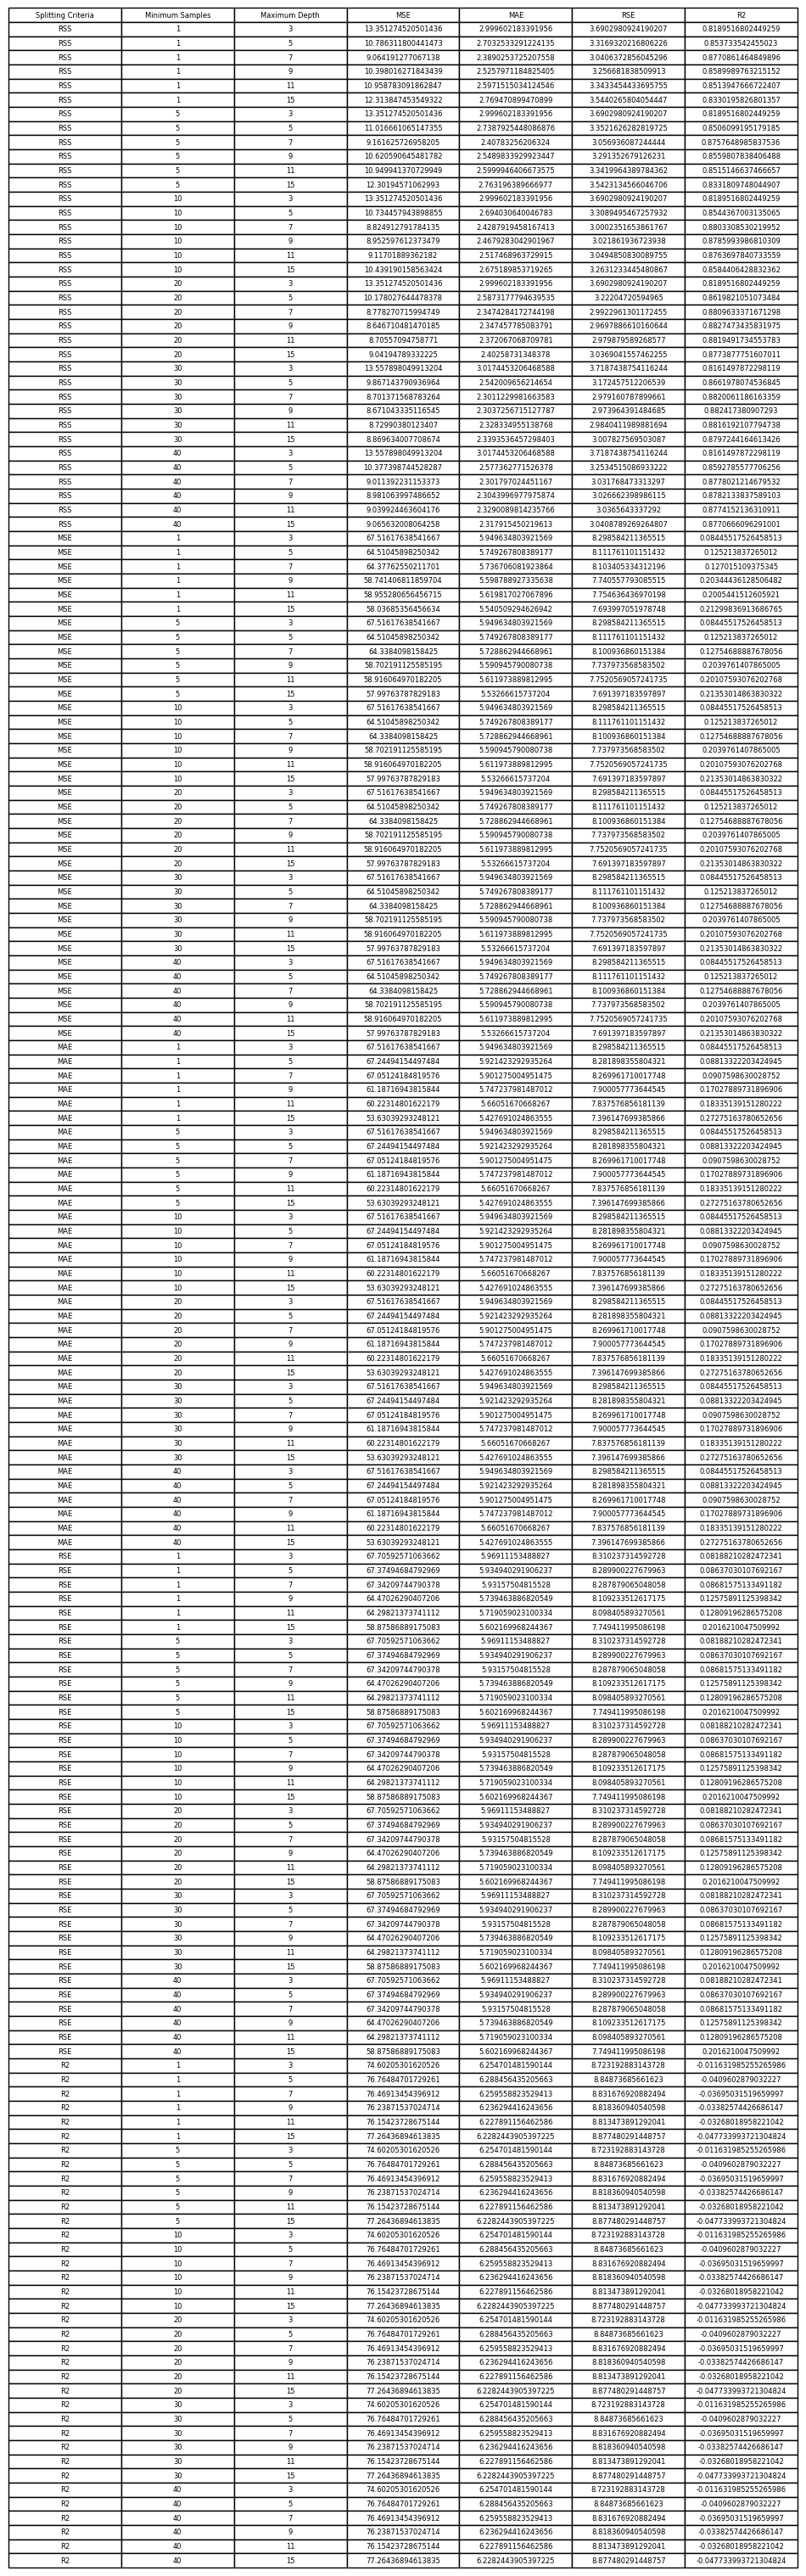

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc = 'center', loc='center')

plt.show()

From the table we can conclude that for all the metrics, we get the best scores by using RSS splitting criteria. The R2 splitting criteria seems to give us the worst scores, which are drastically worse then the one derived using RSS.



Now, let's see what is the mean results we get for each metric from each parameter.

In [44]:
results_df.groupby('Splitting Criteria').mean().iloc[:, 2:]

,MSE,MAE,RSE,R2
Splitting Criteria,,,,
MAE,62.808845,5.767963,7.997371,0.148288
MSE,62.001180,5.694763,7.949069,0.159241
R2,76.248893,6.249191,8.818820,-0.033964
RSE,65.011219,5.816053,8.140845,0.118423
RSS,10.356278,2.571169,3.239900,0.859565


Also here we see how much the scores improve by simply using RSS for splitting criteria.

In [46]:
results_df.groupby('Minimum Samples').mean().iloc[:, 1:]

<ipython-input-46-ee01b83242b4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby('Minimum Samples').mean().iloc[:, 1:]


,MSE,MAE,RSE,R2
Minimum Samples,,,,
1,55.447466,5.239276,7.254569,0.248111
5,55.459891,5.240700,7.257000,0.247943
10,55.260471,5.231520,7.225629,0.250647
20,55.169883,5.207302,7.210871,0.251876
30,55.159723,5.199820,7.209037,0.252013
40,55.214266,5.200351,7.218100,0.251274


The size of the minimum samples doesn't really seem to affect the scores much, but there is a low improvement by increasing them, which is expected.

In [47]:
results_df.groupby('Maximum Depth').mean().iloc[:, 1:]

<ipython-input-47-d578ff6c91a3>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby('Maximum Depth').mean().iloc[:, 1:]


,MSE,MAE,RSE,R2
Maximum Depth,,,,
3,58.152096,5.425727,7.466076,0.211436
5,57.277706,5.306910,7.360659,0.223293
7,56.826209,5.237049,7.301541,0.229415
9,53.996642,5.146326,7.131222,0.267785
11,53.836345,5.135617,7.124899,0.269959
15,51.622701,5.067340,6.990810,0.299977


The depth affects more the results than the minimum samples. As we can see deeper the tree, better the scores are.

Now let's see, which are the parameters that gave us the best scores and worse scores based on all parameters.

In [48]:
best_params_idx = results_df['MSE'].idxmin()
best_params = results_df.iloc[best_params_idx]
worst_params_idx = results_df['MSE'].idxmax()
worst_params = results_df.iloc[worst_params_idx]
print("Best Parameters:\n", best_params)
print("Worst Parameters:\n", worst_params)

Best Parameters:
 Splitting Criteria         RSS
Minimum Samples             20
Maximum Depth                9
MSE                    8.64671
MAE                   2.347458
RSE                   2.969789
R2                    0.882747
Name: 21, dtype: object
Worst Parameters:
 Splitting Criteria           R2
Minimum Samples               1
Maximum Depth                15
MSE                   77.264369
MAE                    6.228244
RSE                     8.87748
R2                    -0.047734
Name: 149, dtype: object


In [49]:
best_params_idx = results_df['MAE'].idxmin()
best_params = results_df.iloc[best_params_idx]
worst_params_idx = results_df['MAE'].idxmax()
worst_params = results_df.iloc[worst_params_idx]
print("Best Parameters:\n", best_params)
print("Worst Parameters:\n", worst_params)

Best Parameters:
 Splitting Criteria         RSS
Minimum Samples             30
Maximum Depth                7
MSE                   8.701372
MAE                   2.301123
RSE                   2.979161
R2                    0.882006
Name: 26, dtype: object
Worst Parameters:
 Splitting Criteria           R2
Minimum Samples               1
Maximum Depth                 5
MSE                   76.764847
MAE                    6.288456
RSE                    8.848737
R2                     -0.04096
Name: 145, dtype: object


In [50]:
best_params_idx = results_df['RSE'].idxmin()
best_params = results_df.iloc[best_params_idx]
worst_params_idx = results_df['RSE'].idxmax()
worst_params = results_df.iloc[worst_params_idx]
print("Best Parameters:\n", best_params)
print("Worst Parameters:\n", worst_params)

Best Parameters:
 Splitting Criteria         RSS
Minimum Samples             20
Maximum Depth                9
MSE                    8.64671
MAE                   2.347458
RSE                   2.969789
R2                    0.882747
Name: 21, dtype: object
Worst Parameters:
 Splitting Criteria           R2
Minimum Samples               1
Maximum Depth                15
MSE                   77.264369
MAE                    6.228244
RSE                     8.87748
R2                    -0.047734
Name: 149, dtype: object


In [51]:
best_params_idx = results_df['R2'].idxmax()
best_params = results_df.iloc[best_params_idx]
worst_params_idx = results_df['R2'].idxmin()
worst_params = results_df.iloc[worst_params_idx]
print("Best Parameters:\n", best_params)
print("Worst Parameters:\n", worst_params)

Best Parameters:
 Splitting Criteria         RSS
Minimum Samples             20
Maximum Depth                9
MSE                    8.64671
MAE                   2.347458
RSE                   2.969789
R2                    0.882747
Name: 21, dtype: object
Worst Parameters:
 Splitting Criteria           R2
Minimum Samples               1
Maximum Depth                15
MSE                   77.264369
MAE                    6.228244
RSE                     8.87748
R2                    -0.047734
Name: 149, dtype: object


We can now conclude that using **splitting criteria** RSS, **minimum samples** 20 and **maximum depth** 9 seem to give us best results. Now using these values let's compare our model with the scikit learn's implementation of Regression tree.

In [52]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

In [53]:
# Number of splits for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [54]:
mse_custom, mae_custom, rse_custom, r2_custom = [], [], [], []
mse_sklearn, mae_sklearn, rse_sklearn, r2_sklearn = [], [], [], []

for train_idx, test_idx in tqdm(kf.split(X), total=kf.get_n_splits(), desc="KFold Progress"):
  # Split the data
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # Train and evaluate the custom regression tree
  custom_tree = RegressionTree(max_depth=9, min_samples=20)
  custom_tree.fit(X_train, y_train)
  y_pred_custom = custom_tree.predict(X_test)
  mse, mae, rse, r2 = custom_tree.evaluate(y_test, y_pred_custom)
  mse_custom.append(mse)
  mae_custom.append(mae)
  rse_custom.append(rse)
  r2_custom.append(r2)

  # Train and evaluate the scikit-learn regression tree
  sklearn_tree = DecisionTreeRegressor(max_depth=9, min_samples_leaf=20)
  sklearn_tree.fit(X_train, y_train)
  y_pred_sklearn = sklearn_tree.predict(X_test)
  mse, mae, rse, r2 = custom_tree.evaluate(y_test, y_pred_sklearn)
  mse_sklearn.append(mse)
  mae_sklearn.append(mae)
  rse_sklearn.append(rse)
  r2_sklearn.append(r2)

KFold Progress: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


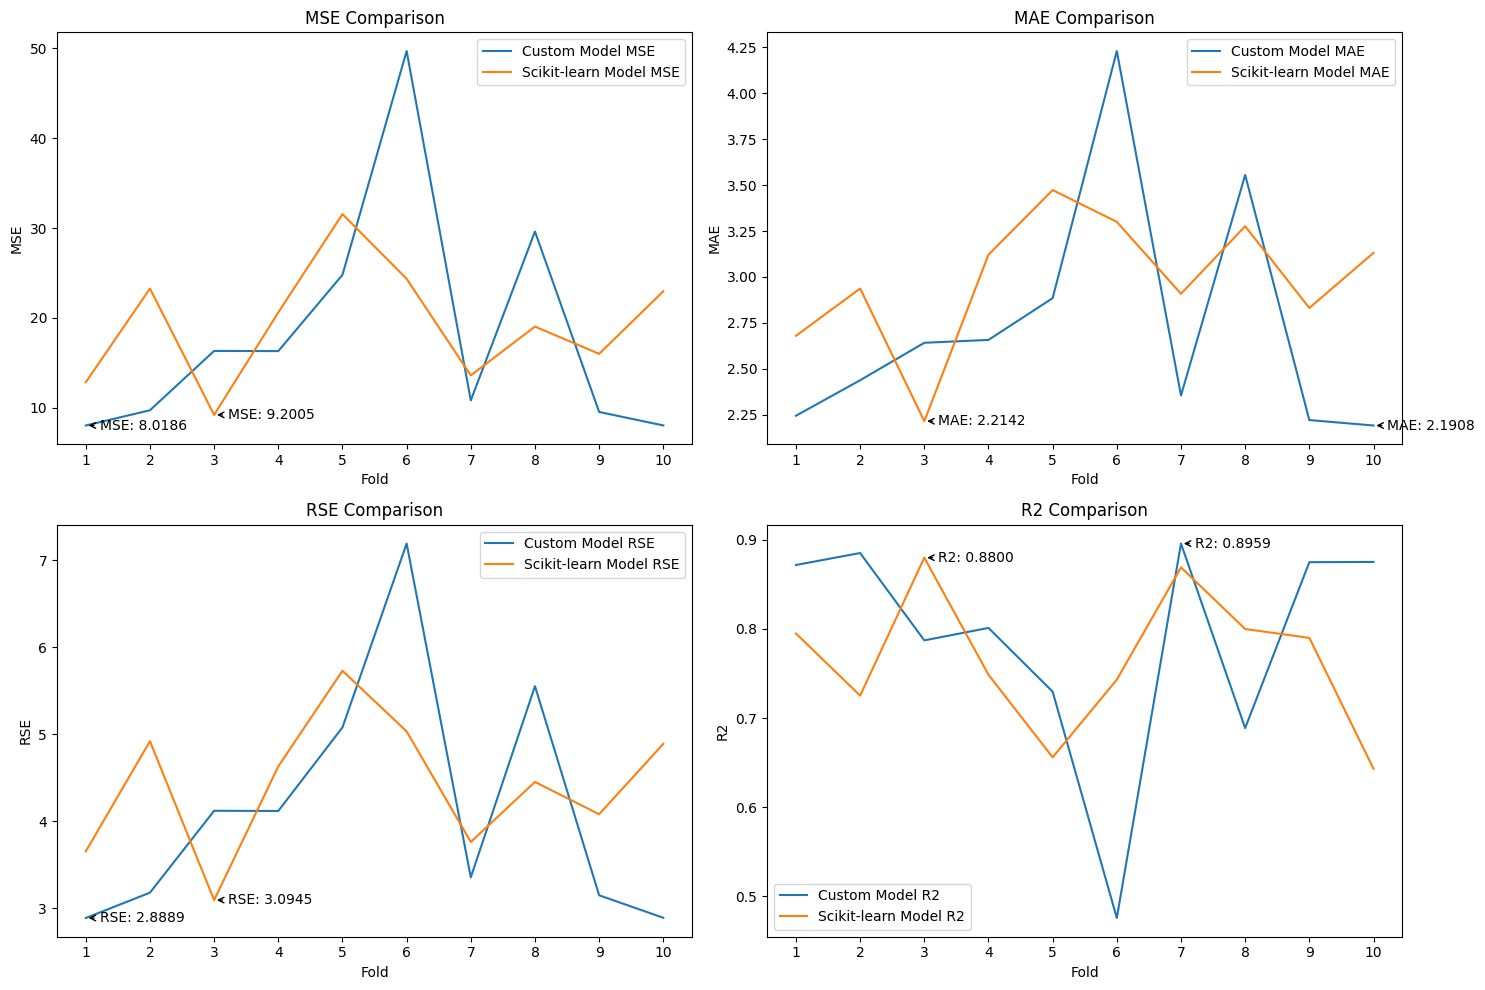

In [55]:
metrics_custom = [mse_custom, mae_custom, rse_custom, r2_custom]
metrics_sklearn = [mse_sklearn, mae_sklearn, rse_sklearn, r2_sklearn]
metric_names = ['MSE', 'MAE', 'RSE', 'R2']
is_max_better = [False, False, False, True]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
  x_data = range(1, len(metrics_custom[i]) + 1)
  ax.plot(x_data, metrics_custom[i], label='Custom Model ' + metric_names[i])
  ax.plot(x_data, metrics_sklearn[i], label='Scikit-learn Model ' + metric_names[i])

  # Determine the best value for custom model
  if is_max_better[i]:
      best_idx_custom = np.argmax(metrics_custom[i])
  else:
      best_idx_custom = np.argmin(metrics_custom[i])
  best_value_custom = metrics_custom[i][best_idx_custom]

  # Determine the best value for sklearn model
  if is_max_better[i]:
      best_idx_sklearn = np.argmax(metrics_sklearn[i])
  else:
      best_idx_sklearn = np.argmin(metrics_sklearn[i])
  best_value_sklearn = metrics_sklearn[i][best_idx_sklearn]

  # Annotate the best value for custom model
  ax.annotate(f"{metric_names[i]}: {best_value_custom:.4f}",
              xy=(best_idx_custom + 1, best_value_custom),
              xytext=(10, 0), textcoords='offset points',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
              ha='left', va='center')

  # Annotate the best value for sklearn model
  ax.annotate(f"{metric_names[i]}: {best_value_sklearn:.4f}",
              xy=(best_idx_sklearn + 1, best_value_sklearn),
              xytext=(10, 0), textcoords='offset points',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
              ha='left', va='center')

  ax.set_xticks(x_data)
  ax.set_title(f'{metric_names[i]} Comparison')
  ax.set_xlabel('Fold')
  ax.set_ylabel(metric_names[i])
  ax.legend()

plt.tight_layout()
plt.show()

From the plots we can conclude the following things:
- The difference in the performance of both implementations for each split is not so small.
- Watching the globally best value for each score, our implementation seem to give better values.
- We can see tendency that on the 3rd, 6th and 8th split for each of the metric our algorithm gives worse scores.
- Anyway, in general (the other 7 splits) our implementation of the Regression tree seems to have better performance.